# Import Modules

In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import random
import os
import time
import copy
import math
from sklearn.model_selection import KFold
%matplotlib inline

# Assign Variables

In [743]:
training_filename = "data/training.csv"
testing_filename = "data/test.csv"
lookup_tale_filename = "/data/IdLookupTable.csv"
batch_size = 64

# Images are 96 x 96 grayscale with 15x2 features
image_size = 96
num_labels = 30
channels = 1

# Distort Input
flip_images = True
brighten_images = True
noisy_images = True
rotate_images = True

# Load Data

In [579]:
def load(seed):
    
    filename = training_filename
    df = pd.read_csv(filename)  # load pandas dataframe

    #get 
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    #
    df = df.dropna()  
    #
    images = (np.vstack(df['Image'].values) / 255) .astype(np.float32)
    image = images.reshape(-1, image_size, image_size, channels)
    
    labels = df[df.columns[:-1]].values
    labels = (label - 48) / 48  # scale target coordinates to [-1, 1]
    random.seed(seed)
    random.shuffle(X)
    labels = label.astype(np.float32)
    random.seed(seed)
    random.shuffle(y)
    

    return images, labels

# Wrapper for load() that reshapes the input to a image_size x image_size x channels
def loadData():
    x_image, y_label = load()
    x_image = x_image.reshape(-1, image_size, image_size, channels)
    return x_image, y_label

In [6]:
x_images, y_labels = loadData(25)

## Split data using Hold Out

In [7]:
def splitData(data, percentage):
    data1 = data[:int(len(data)*percentage)]
    data2 = data[int(len(data)*percentage)+1:]
    
    return data1, data2

In [485]:
x_train, x_validate = splitData(x_images, 0.7)
y_train, y_validate = splitData(y_labels, 0.7)

In [723]:
flip_indices_all = [
        (0, 2), (1, 3),
        (4, 8), (5, 9), (6, 10), (7, 11),
        (12, 16), (13, 17), (14, 18), (15, 19),
        (22, 24), (23, 25),
        ]

In [10]:
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

In [11]:
def rotatePoint(centerPoint,point,angle):
    """Rotates a point around another centerPoint. Angle is in degrees.
    Rotation is counter-clockwise"""
    angle = math.radians(angle)
    temp_point = point[0]-centerPoint[0] , point[1]-centerPoint[1]
    temp_point = ( temp_point[0]*math.cos(angle)-temp_point[1]*math.sin(angle) , temp_point[0]*math.sin(angle)+temp_point[1]*math.cos(angle))
    temp_point = temp_point[0]+centerPoint[0] , temp_point[1]+centerPoint[1]
    return temp_point

In [767]:
def batch(x_data,y_data=None, flip_indices = flip_indices_all, batches=1):
    x_temp = copy.deepcopy(x_data)
    y_temp = copy.deepcopy(y_data)
    length = len(x_temp)
    
        # flip images to add artificially inflate dataset
    if flip_images:
        # 50% chance to flip
        data_shape = x_temp.shape[0]
        indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
        x_temp[indices] = x_temp[indices, :, ::-1]

        if y_temp is not None:
            y_temp[indices, ::2] = y_temp[indices, ::2] * -1

            # Swap places, e.g. left_eye_center_x -> right_eye_center_x
            for a, b in flip_indices:
                y_temp[indices, a], y_temp[indices, b] = (y_temp[indices, b], y_temp[indices, a])
                
    if brighten_images:
        data_shape = x_temp.shape[0]
        indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
        #print(x_temp[0,0])
        x_temp[indices] = x_temp[indices]*random.uniform(0.55, 1.55)
        
        
    if noisy_images:
        data_shape = x_temp.shape[0]
        indices = np.random.choice(data_shape, (int)(data_shape / 2), replace=False)
        x_temp[indices] = x_temp[indices] + np.random.normal(-0.3, 0.3) * x_temp[indices].std() * np.random.random(x_temp[indices].shape)
    

    if rotate_images:
        for i in range(0, len(x_temp)): 
            if random.uniform(0, 1) > .5:
                angle = random.uniform(-10, 10)
                x_temp[i] = np.reshape(misc.imrotate(np.reshape(x_temp[i], [image_size, image_size]), -angle), [image_size, image_size, 1])
                for j in range(0, num_labels, 2):
                    y_temp[i, j], y_temp[i, j+1] = rotatePoint((0, 0), (y_temp[i, j], y_temp[i, j+1]), angle)
                    
    # return iterations
    for index in range(0, length, batches):
        if y_temp is None:
            yield x_temp[index:min(index + batches, length)]
        else:
            yield x_temp[index:min(index + batches, length)], y_temp[index:min(index + batches, length)]

# Build Convolutional Neural Network Model

In [13]:
def createConvolutionLayer(x_input, kernel_size, features, depth):
    # createConvolutionLayer generates a convolution layer in the session graph
    # by assigning weights, biases, convolution and relu function
    #
    # x_input - output from the previous layer
    # kernel_size - size of the feature kernels
    # depth - number of feature kernels
    #
    # returns convolution layer in graph
    #
    print("conv: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[kernel_size, kernel_size, features, depth],
                             initializer = tf.contrib.layers.xavier_initializer())
    
    biases = tf.get_variable('biases', shape=[depth], initializer=tf.constant_initializer(0))
    
    convolution = tf.nn.conv2d(x_input, weights, strides=[1,1,1,1], padding='SAME')
    
    added = tf.nn.bias_add(convolution, biases)
    
    return tf.nn.relu(added)

In [14]:
def createFullyConnectedLayer(x_input, width):
    # createFullyConnectedLayer generates a fully connected layer in the session graph
    # 
    # x_input - output from previous layer
    # width - width of the layer (eg for a 10 class output you need to end with a 10 width layer
    #
    # returns fully connected layer in graph
    #
    print("fc: input size: " + str(x_input.get_shape()))
    weights = tf.get_variable('weights', shape=[x_input.get_shape()[1], width],
                             initializer = tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable('biases', shape=[width], initializer=tf.constant_initializer(0))
     
    matrix_multiply = tf.matmul(x_input, weights)
    
    return tf.nn.bias_add(matrix_multiply, biases)

In [15]:
def createLinearRectifier(x_input):
    # createLinearRectifier generates a ReLu in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # width - width of the layer
    #
    # returns ReLu in graph
    # 
    
    return tf.nn.relu(x_input)

In [16]:
def createPoolingLayer(x_input, kernel_size):
    # createPoolingLayer generates a pooling layer in the session graph
    # 
    # The reason this exists is due to the last fully connected layer not needing a relu while others do
    # x_input - output from previous layer
    # kernel_size - size of the kernel
    #
    # returns pooling layer in graph
    # 
    print("pool: input size: " + str(x_input.get_shape()))
    return tf.nn.max_pool(x_input, ksize=[1, kernel_size, kernel_size, 1], strides=[1,kernel_size,kernel_size, 1], padding='SAME')

In [17]:
def createNetwork1(x_input):
    with tf.variable_scope('in'):
        x_input = tf.reshape(x_input, [-1, image_size*image_size])
    with tf.variable_scope('hidden'):
        hidden_fully_connected_layer = createFullyConnectedLayer(x_input, 100)
        relu_layer = createLinearRectifier(hidden_fully_connected_layer)
    with tf.variable_scope('out'):
        return createFullyConnectedLayer(relu_layer, 30)

In [18]:
def createNetwork2(x_input, isTraining):
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 1, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer1, keep_prob=0.9), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 32, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer2, keep_prob=0.8), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 64, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer3, keep_prob=0.7), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    print("fc: input size before flattening: " + str(pooling_layer3.get_shape()))
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 500)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(isTraining, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob=0.5), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 500)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, num_labels)
        print("out: " + str(output.get_shape()))
    return output

In [688]:
def createCenterEyeNetwork(x_input, isTraining):
    # Define convolution layers
    with tf.variable_scope('conv1'):
        convolution_layer1 = createConvolutionLayer(x_input, 3, 1, 32)
        pooling_layer1 = createPoolingLayer(convolution_layer1, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer1 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer1, keep_prob=0.9), lambda: pooling_layer1)
    with tf.variable_scope('conv2'):
        convolution_layer2 = createConvolutionLayer(pooling_layer1, 2, 32, 64)
        pooling_layer2 = createPoolingLayer(convolution_layer2, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer2 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer2, keep_prob=0.8), lambda: pooling_layer2)
    with tf.variable_scope('conv3'):
        convolution_layer3 = createConvolutionLayer(pooling_layer2, 2, 64, 128)
        pooling_layer3 = createPoolingLayer(convolution_layer3, 2)
        # Determine if used for training or test/validate. Only use dropout for training
        pooling_layer3 = tf.cond(isTraining, lambda: tf.nn.dropout(pooling_layer3, keep_prob=0.7), lambda: pooling_layer3)
    
    # Flatten output to connect to fully connected layers
    print("fc: input size before flattening: " + str(pooling_layer3.get_shape()))
    pooling_layer3_shape = pooling_layer3.get_shape().as_list()
    pooling_layer3_flattened = tf.reshape(pooling_layer3, [-1, pooling_layer3_shape[1] * pooling_layer3_shape[2] * pooling_layer3_shape[3]])
    
    # Define fully connected layers
    with tf.variable_scope('fc1'):
        fully_connected_layer1 = createFullyConnectedLayer(pooling_layer3_flattened, 500)
        fully_connected_relu1 = createLinearRectifier(fully_connected_layer1)
        fully_connected_relu1 = tf.cond(isTraining, lambda: tf.nn.dropout(fully_connected_relu1, keep_prob=0.5), lambda: fully_connected_relu1)
    with tf.variable_scope('fc2'):
        fully_connected_layer2 = createFullyConnectedLayer(fully_connected_relu1, 500)
        fully_connected_relu2 = createLinearRectifier(fully_connected_layer2)
    with tf.variable_scope('out'):
        output = createFullyConnectedLayer(fully_connected_relu2, 4)
        print("out: " + str(output.get_shape()))
    return output
    

In [571]:
graph = tf.Graph()

with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1])
    y_output = tf.placeholder(tf.float32, shape=[None, num_labels])
    is_training = tf.placeholder(tf.bool)

    current_epoch = tf.Variable(0)  # count the number of epochs
    
    num_epochs = 300
    dropout = False
    global_step = tf.Variable(0, trainable=False)
    
    #learning rate options
    #learning_rate = tf.train.exponential_decay(.0005, global_step, num_epochs, 0.95, staircase = True) 
    learning_rate = 0.0005
    
    #optimizer
    momentum_rate = .9
    
    # get model
    #prediction_output = createNetwork1(x_input)
    prediction_output = createNetwork2(x_input, is_training)
    
    loss_function = tf.reduce_mean(tf.square(prediction_output - y_output))
    
    #optimization methods
    #optimizer = tf.train.MomentumOptimizer(learning_rate, momentum_rate, use_nesterov=True).minimize(loss_function, global_step = global_step)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function, global_step = global_step)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_function, global_step = global_step)


conv: input size: (?, 96, 96, 1)
pool: input size: (?, 96, 96, 32)
conv: input size: (?, 48, 48, 32)
pool: input size: (?, 48, 48, 64)
conv: input size: (?, 24, 24, 64)
pool: input size: (?, 24, 24, 128)
fc: input size before flattening: (?, 12, 12, 128)
fc: input size: (?, 18432)
fc: input size: (?, 500)
fc: input size: (?, 500)
out: (?, 30)


# Name your model

In [576]:
model_name = "WhatsUp2"
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/Models/" + model_name
model_path = model_directory + "/" + model_filename

In [449]:
def getPredictionsInBatches(X, session):
    
    p = []
    for step in range(int(X.shape[0] / batch_size)+1):    
        offset = step * batch_size 
        if offset+batch_size > X.shape[0]:
            batch_data = X[offset:X.shape[0], ...]
        else:
            batch_data = X[offset:(offset + batch_size), ...]
            
        [p_batch] = session.run([prediction_output], feed_dict = {x_input : batch_data, is_training : False}
        )
        p.extend(p_batch)
    return p

In [450]:
def getTime(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    
    return h, m, s

In [451]:
def lossFunction(predict, actual):
    return np.mean(np.square(predict - actual))

# Train Model

In [577]:
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
epoch_list = []
print("TRAINING: " + model_name)
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(model_directory):
        print("Loading model...")
        load_path = saver.restore(session, model_path)
    for current_epoch in range(num_epochs):
        for batch_data, labels in batch(x_train, y_train, flip_indices_all, batch_size):
            feed_dict = {x_input: batch_data, y_output: labels, is_training: dropout}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)
        
        if current_epoch % 10 == 0:
            train_loss = lossFunction(getPredictionsInBatches(x_train, session), y_train)
            train_loss = loss_function.eval(feed_dict = {x_input: x_train, y_output: y_train, is_training: False})
            train_loss_list.append(train_loss)
            valid_loss = lossFunction(getPredictionsInBatches(x_validate, session), y_validate)
            valid_loss = loss_function.eval(feed_dict = {x_input: x_validate, y_output: y_validate, is_training: False})
            valid_loss_list.append(valid_loss)
            
            current_time = time.time() - start
            hours, minutes, seconds = getTime(current_time)
            
            print("Epoch[%4d]" % current_epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate + "%f" % momentum_rate)
            
            time_list.append(current_time)
            epoch_list.append(current_epoch)
              
        if current_epoch % 300 == 0:
            if not os.path.exists(model_directory):
                os.mkdir(model_directory)
            print("Saving Model...")    
            save_path = saver.save(session, model_path)
        # Evaluate on test dataset.
    if not os.path.exists(model_directory):
        os.mkdir(model_directory)
    print("Saving Model...")
    save_path = saver.save(session, model_path)

TRAINING: WhatsUp2
Epoch[   0]0: 0: 2 0.007745  0.008142 0.000500 0.900000
Saving Model...
Epoch[  10]0: 0:14 0.000758  0.001520 0.000500 0.900000
Epoch[  20]0: 0:24 0.000393  0.001150 0.000500 0.900000
Epoch[  30]0: 0:35 0.000298  0.001183 0.000500 0.900000
Epoch[  40]0: 0:46 0.000235  0.001103 0.000500 0.900000
Epoch[  50]0: 0:57 0.000263  0.001036 0.000500 0.900000
Epoch[  60]0: 1: 7 0.000354  0.001103 0.000500 0.900000
Epoch[  70]0: 1:18 0.000298  0.001144 0.000500 0.900000
Epoch[  80]0: 1:29 0.000147  0.000956 0.000500 0.900000
Epoch[  90]0: 1:40 0.000143  0.000977 0.000500 0.900000
Epoch[ 100]0: 1:50 0.000102  0.000913 0.000500 0.900000
Epoch[ 110]0: 2: 1 0.000101  0.000935 0.000500 0.900000
Epoch[ 120]0: 2:12 0.000086  0.000936 0.000500 0.900000
Epoch[ 130]0: 2:23 0.000139  0.000942 0.000500 0.900000
Epoch[ 140]0: 2:33 0.000105  0.000963 0.000500 0.900000
Epoch[ 150]0: 2:44 0.000260  0.001180 0.000500 0.900000
Epoch[ 160]0: 2:55 0.000160  0.000961 0.000500 0.900000
Epoch[ 170]0:

# Get Labels and Save

In [523]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    [p] = session.run([prediction_output], feed_dict={x_input: test_images, is_training:False})
    #test_loss = loss_function.eval(feed_dict={x_input:np.reshape(x_validate[212], [-1, 96, 96, 1]), y_output: np.reshape(y_validate[212], [-1, 30]), is_training:False})
    test_loss = loss_function.eval(feed_dict={x_input:x_validate, y_output: y_validate, is_training:False})
    print("Test Loss Score: " + str(np.sqrt(test_loss)*48))
    print("Test Loss: " + str(test_loss))

Test Loss Score: 0.695087492466
Test Loss: 0.000209699


In [204]:
p

array([[ 0.40847263, -0.26518178, -0.3774448 , -0.25972915,  0.27719802,
        -0.24869211,  0.52894294, -0.24165235, -0.2435564 , -0.24466705,
        -0.50784862, -0.23269761,  0.22146662, -0.47980905,  0.68107742,
        -0.41666251, -0.1782743 , -0.47122294, -0.659491  , -0.41181707,
         0.0377923 ,  0.09540783,  0.32682449,  0.55018771, -0.25383887,
         0.54387695,  0.03520451,  0.41253003,  0.03242654,  0.71844625]], dtype=float32)

In [483]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    load_path = saver.restore(session, model_path)
    [p] = session.run([prediction_output], feed_dict={x_input: x_validate, is_training:False})
    test_loss = loss_function.eval(feed_dict={x_input:x_validate, y_output: y_validate, is_training:False})
    print("Test Loss: " + str(test_loss))
import pandas as pd

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Data': [p]})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Labels.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Loss1.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Test': test_loss})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'TestLoss3.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Test Loss: 0.000271892


In [216]:
np.sqrt(test_loss) * 48

1.4393688440322876

# Ouput Test Example Images

In [477]:
print(p)

[[ 0.3902806  -0.20332345 -0.38371959 ...,  0.52379978 -0.09780452
   0.80567235]
 [ 0.3902806  -0.20332345 -0.38371959 ...,  0.52379978 -0.09780452
   0.80567235]
 [ 0.3902806  -0.20332345 -0.38371959 ...,  0.52379978 -0.09780452
   0.80567235]
 ..., 
 [ 0.35267231 -0.24201128 -0.3641364  ...,  0.42844266  0.05032529
   0.65563285]
 [ 0.35112786 -0.27347761 -0.40156475 ...,  0.33646154 -0.01254162
   0.59127229]
 [ 0.42078099 -0.22584546 -0.41527271 ...,  0.50901181 -0.02149939
   0.80498827]]


IndexError: index 200 is out of bounds for axis 0 with size 1

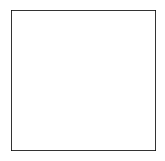

In [582]:
fig = plt.figure(figsize=(15, 15))
#fig.subplots_adjust(
#    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

offset = 200

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_images[i + offset]
    img = img.reshape(96, 96)
    y = test_images[i + offset]
    y2 = p[i + offset]
    axis.imshow(img, cmap='gray')
    # Actual labels
    #axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10, color='red')
    # Predicted labels
    axis.scatter(y2[0::2] * 48 + 48, y2[1::2] * 48 + 48, marker='x', s=10, color='lime')
plt.show()

# Try K folds cross validation
Even though your model has low validation loss doesn't mean its a well trained model. It's possible that it is overfitting to the data. One thing we can do beyond looking at the different between the training and validation loss is running cross validation to see the statistics between the same model being trained on different partitions(folds) of datasets.

In [598]:
x, y = loadData()

In [599]:
k_folds = 5

width = int(len(x)/k_folds)
folds_data = []
folds_labels = []

for i in range(0, len(x), width):
    if (i + width) > len(x):
        end = len(x)
    else:
        end = i + width
    folds_data.append(x[i:i+width])
    folds_labels.append(y[i:i+width])

In [606]:
graph = tf.Graph()

with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1])
    y_output = tf.placeholder(tf.float32, shape=[None, num_labels])
    is_training = tf.placeholder(tf.bool)

    current_epoch = tf.Variable(0)  # count the number of epochs
    
    num_epochs = 500
    dropout = False
    global_step = tf.Variable(0, trainable=False)
    
    #learning rate options
    #learning_rate = tf.train.exponential_decay(.0005, global_step, num_epochs, 0.95, staircase = True) 
    learning_rate = 0.0005
    
    # get model
    prediction_output = createNetwork2(x_input, is_training)
    loss_function = tf.reduce_mean(tf.square(prediction_output - y_output))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function, global_step = global_step)

conv: input size: (?, 96, 96, 1)
pool: input size: (?, 96, 96, 32)
conv: input size: (?, 48, 48, 32)
pool: input size: (?, 48, 48, 64)
conv: input size: (?, 24, 24, 64)
pool: input size: (?, 24, 24, 128)
fc: input size before flattening: (?, 12, 12, 128)
fc: input size: (?, 18432)
fc: input size: (?, 500)
fc: input size: (?, 500)
out: (?, 30)


In [607]:
def nameModel(model_name):
    model_filename = model_name + ".ckpt"
    model_directory = os.getcwd() + "/Models/" + model_name
    model_path = model_directory + "/" + model_filename
    return model_directory, model_path

# Driver for Cross Validation

In [608]:
train_labels.shape

(1712, 30)

In [609]:
name = 'ADAM0.005EPOCHNODROPOUT'

for j in range(0, k_folds):
    print("TESTING FOLD " + str(j))
    model_directory, model_path = nameModel(name + "CV" + str(j))
    test_data = np.array([])
    test_labels = np.array([])
    train_data = np.array([])
    train_labels = np.array([])
    
    for i in range(0, k_folds):
        if(i==j):
            if test_data.size == 0:
                test_data = folds_data[i]
                test_labels = folds_labels[i]
            else:

                test_data = np.concatenate((test_data, folds_data[i]))
                test_labels = np.concatenate((test_labels, folds_labels[i]))
        else:
            if train_data.size == 0:
                train_data = folds_data[i]
                train_labels = folds_labels[i]
            else:
                train_data = np.concatenate((train_data, folds_data[i]))
                train_labels = np.concatenate((train_labels, folds_labels[i]))
                
    #train(x_train, y_train, x_validate, y_validate, graph, num_epochs, model_directory, model_path, name + "CV" + str(j))
    
    train(train_data, train_labels, test_data, test_labels, graph, num_epochs, model_directory, model_path, name + "CV" + str(j))
print("Finished CV")

TESTING FOLD 0
TRAINING: ADAM0.005EPOCHNODROPOUTCV0
New model
Epoch[   0]0: 0: 1 0.004634  0.004058 0.000500 0.900000
Saving Model...
Epoch[  10]0: 0:14 0.000884  0.000734 0.000500 0.900000
Epoch[  20]0: 0:26 0.000523  0.000489 0.000500 0.900000
Epoch[  30]0: 0:38 0.000352  0.000356 0.000500 0.900000
Epoch[  40]0: 0:50 0.000298  0.000329 0.000500 0.900000
Epoch[  50]0: 1: 2 0.000250  0.000295 0.000500 0.900000
Epoch[  60]0: 1:14 0.000228  0.000283 0.000500 0.900000
Epoch[  70]0: 1:26 0.000244  0.000305 0.000500 0.900000
Epoch[  80]0: 1:38 0.000262  0.000327 0.000500 0.900000
Epoch[  90]0: 1:50 0.000163  0.000246 0.000500 0.900000
Epoch[ 100]0: 2: 2 0.000102  0.000186 0.000500 0.900000
Epoch[ 110]0: 2:13 0.000136  0.000227 0.000500 0.900000
Epoch[ 120]0: 2:25 0.000236  0.000306 0.000500 0.900000
Epoch[ 130]0: 2:37 0.000130  0.000213 0.000500 0.900000
Epoch[ 140]0: 2:49 0.000114  0.000203 0.000500 0.900000
Epoch[ 150]0: 3: 1 0.000209  0.000308 0.000500 0.900000
Epoch[ 160]0: 3:13 0.00010

In [432]:
train_data.shape

(1712, 96, 96, 1)

In [433]:
test_data.shape

(428, 96, 96, 1)

In [434]:
def train(train_data, train_labels, validate_data, validate_labels, graph, num_epochs, model_directory, model_path, model_name):
    start = time.time()
    train_loss_list = []
    valid_loss_list = []
    time_list = []
    epoch_list = []
    print("TRAINING: " + model_name)
    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        if os.path.exists(model_directory):
            print("Loading model...")
            load_path = saver.restore(session, model_path)
        else:
            print("New model")
        for current_epoch in range(num_epochs):
            for batch_data, labels in batch(train_data, train_labels, flip_indices_all, batch_size):
                feed_dict = {x_input: batch_data, y_output: labels, is_training: dropout}
                # training and optimizing
                session.run([optimizer], feed_dict = feed_dict)

            if current_epoch % 10 == 0:
                train_loss = lossFunction(getPredictionsInBatches(train_data, session), train_labels)
                train_loss_list.append(train_loss)
                valid_loss = lossFunction(getPredictionsInBatches(validate_data, session), validate_labels)
                valid_loss_list.append(valid_loss)

                current_time = time.time() - start
                hours, minutes, seconds = getTime(current_time)

                print("Epoch[%4d]" % current_epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate + "%f" % momentum_rate)

                time_list.append(current_time)
                epoch_list.append(current_epoch)

            if current_epoch % 300 == 0:
                if not os.path.exists(model_directory):
                    os.mkdir(model_directory)
                print("Saving Model...")    
                save_path = saver.save(session, model_path)
            # Evaluate on test dataset.
        if not os.path.exists(model_directory):
            os.mkdir(model_directory)
        print("Saving Model...")
        save_path = saver.save(session, model_path)
        
        # Create a Pandas dataframe from some data.
        df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})
        writer = pd.ExcelWriter(model_path + 'Loss1.xlsx', engine='xlsxwriter')
        df.to_excel(writer, sheet_name='Sheet1')
        writer.save()
        print("Finished Training " + model_name)

In [352]:
data_out = folds_data[0]
new_data1 = data_out[0]
new_data2 = data_out[1]

print(new_data1.shape)
data_array = np.empty(folds_data[0].shape)
data_array = np.concatenate((data_array, np.reshape(new_data1, [1, 96, 96, 1])))

(96, 96, 1)


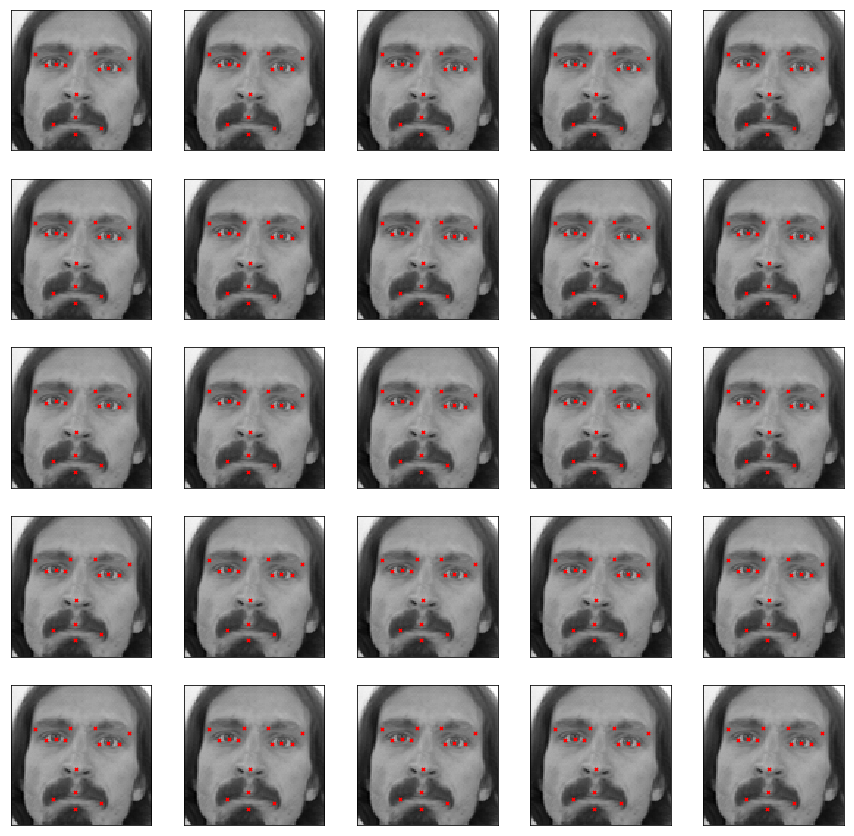

In [446]:
fig = plt.figure(figsize=(15, 15))


for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_data[0]
    #img = x_validate[0]
    img = img.reshape(96, 96)
    y1 = test_labels[0]
    #y1 = y_validate[0]
    axis.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y1[0::2] * 48 + 48, y1[1::2] * 48 + 48, marker='x', s=10, color='red')
plt.show()

In [440]:
x_train.shape

(1711, 96, 96, 1)

In [614]:
def load2(seed):
    
    filename = testing_filename
    df = pd.read_csv(filename)  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    df = df.dropna()  # drop all rows that have missing values in them.
    
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    
    random.seed(seed)
    random.shuffle(X)

    return X

# Wrapper for load() that reshapes the input to a image_size x image_size x channels
def loadTestData():
    x_image = load2(5)
    x_image = np.reshape(x_images, [-1, 96, 96 ,1])
    return x_image

In [615]:
test_images = loadTestData()

In [619]:
test_images = np.reshape(test_images, [-1, 96, 96 ,1])
print(test_images.shape)

(1783, 96, 96, 1)


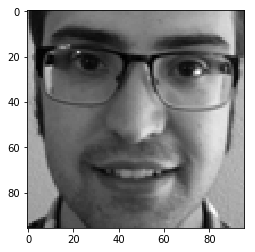

In [568]:
jarrett = mpimg.imread('grayscale.jpg')
jarrett = ((jarrett/256)-48)/48
plt.imshow(jarrett, cmap='gray')

In [620]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    #[p] = session.run([prediction_output], feed_dict={x_input: np.reshape(jarrett, [-1, 96, 96, 1]), is_training:False})
    [p] = session.run([prediction_output], feed_dict={x_input: test_images, is_training:False})
    #test_loss = loss_function.eval(feed_dict={x_input:np.reshape(x_validate[212], [-1, 96, 96, 1]), y_output: np.reshape(y_validate[212], [-1, 30]), is_training:False})
    #test_loss = loss_function.eval(feed_dict={x_input:x_validate, y_output: y_validate, is_training:False})
    print("Test Loss Score: " + str(np.sqrt(test_loss)*48))
    print("Test Loss: " + str(test_loss))

Test Loss Score: 0.695087492466
Test Loss: 0.000209699


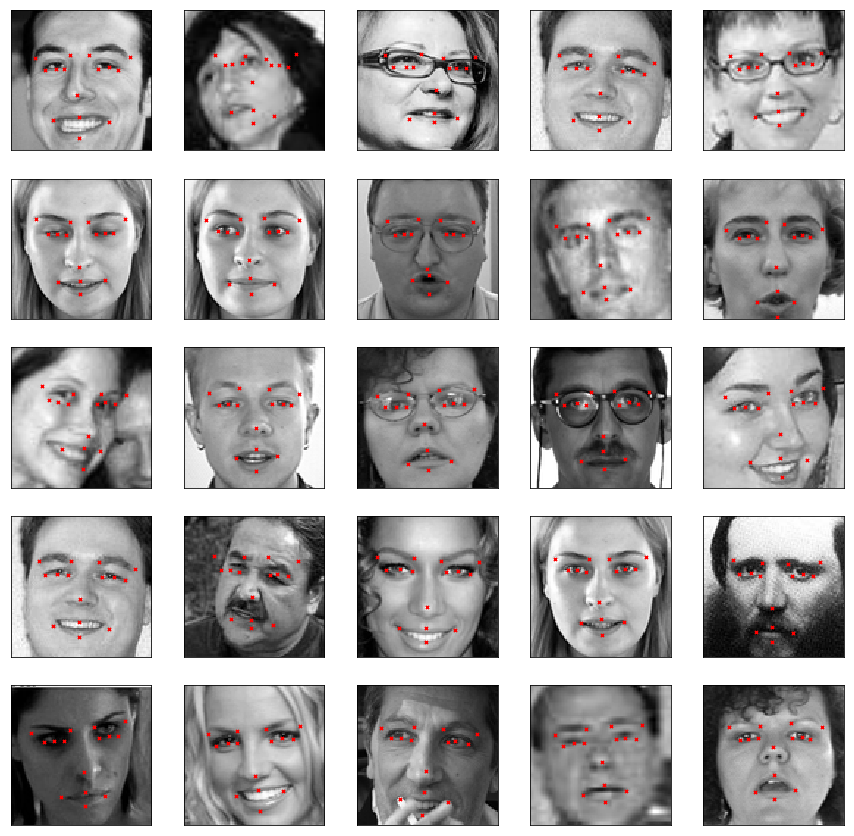

In [629]:
fig = plt.figure(figsize=(15, 15))

offset = 1200

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_images[i+offset]
    img = img.reshape(96, 96)
    y1 = p[i+offset]
    plt.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y1[0::2] * 48 + 48, y1[1::2] * 48 + 48, marker='x', s=10, color='red')
plt.show()

# Create Special Eye Network

In [677]:
def load3(seed, columns = None):
    
    filename = training_filename
    df = pd.read_csv(filename)  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))
    
    if columns:
        df = df[list(columns) + ['Image']]
        print(df.shape)
    df = df.dropna()  # drop all rows that have missing values in them.
    print(df.shape)
    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    y = df[df.columns[:-1]].values
    y = (y - 48) / 48  # scale target coordinates to [-1, 1]
    random.seed(2)
    random.shuffle(X)
    y = y.astype(np.float32)
    random.seed(2)
    random.shuffle(y)


    return X, y

# Wrapper for load() that reshapes the input to a image_size x image_size x channels
def loadMoreData(columns):
    x_image, y_label = load3(5, columns)
    print(len(x_image))
    x_image = x_image.reshape(-1, 96, 96 ,1)
    print(len(x_image))
    return x_image, y_label

In [678]:
train_data, train_labels = loadMoreData(columns = ('left_eye_center_x','left_eye_center_y','right_eye_center_x','right_eye_center_y'))

(7049, 5)
(7033, 5)
7033
7033


In [725]:
flip_indices_center_eyes = ((0, 2), (1,3))

In [689]:
train_data, validation_data = splitData(train_data, 0.7)
train_labels, validation_labels = splitData(train_labels, 0.7)

In [772]:
graph = tf.Graph()

with graph.as_default():
    
    x_input = tf.placeholder(tf.float32, shape=[None, image_size, image_size, 1])
    y_output = tf.placeholder(tf.float32, shape=[None, 4])
    is_training = tf.placeholder(tf.bool)

    current_epoch = tf.Variable(0)  # count the number of epochs
    
    num_epochs = 3000
    dropout = True
    global_step = tf.Variable(0, trainable=False)
    
    #learning rate options
    #learning_rate = tf.train.exponential_decay(.0005, global_step, num_epochs, 0.95, staircase = True) 
    learning_rate = 0.0001
    
    # get model
    prediction_output = createCenterEyeNetwork(x_input, is_training)
    loss_function = tf.reduce_mean(tf.square(prediction_output - y_output))
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_function, global_step = global_step)

conv: input size: (?, 96, 96, 1)
pool: input size: (?, 96, 96, 32)
conv: input size: (?, 48, 48, 32)
pool: input size: (?, 48, 48, 64)
conv: input size: (?, 24, 24, 64)
pool: input size: (?, 24, 24, 128)
fc: input size before flattening: (?, 12, 12, 128)
fc: input size: (?, 18432)
fc: input size: (?, 500)
fc: input size: (?, 500)
out: (?, 4)


In [768]:
model_name = "EyeNetDropoutDataAugmentedRot2"
model_filename = model_name + ".ckpt"
model_directory = os.getcwd() + "/Models/" + model_name
model_path = model_directory + "/" + model_filename

In [769]:
train_data.shape

(4923, 96, 96, 1)

In [773]:
start = time.time()
train_loss_list = []
valid_loss_list = []
time_list = []
epoch_list = []
print("TRAINING: " + model_name)
with tf.Session(graph = graph) as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    if os.path.exists(model_directory):
        print("Loading model...")
        load_path = saver.restore(session, model_path)
    for current_epoch in range(num_epochs):
        for batch_data, labels in batch(train_data, train_labels, flip_indices_center_eyes, batch_size):
            feed_dict = {x_input: batch_data, y_output: labels, is_training: dropout}
            # training and optimizing
            session.run([optimizer], feed_dict = feed_dict)
        
        if current_epoch % 10 == 0:
            train_loss = lossFunction(getPredictionsInBatchesSpecial(train_data, prediction_output, session), train_labels)
            #train_loss = loss_function.eval(feed_dict = {x_input: train_data, y_output: train_labels, is_training: False})
            train_loss_list.append(train_loss)
            valid_loss = lossFunction(getPredictionsInBatchesSpecial(validation_data, prediction_output, session), validation_labels)
            #valid_loss = loss_function.eval(feed_dict = {x_input: validation_data, y_output: validation_labels, is_training: False})
            valid_loss_list.append(valid_loss)
            
            current_time = time.time() - start
            hours, minutes, seconds = getTime(current_time)
            
            print("Epoch[%4d]" % current_epoch + "%d" % hours + ":%2d" % minutes + ":%2d " % seconds + "%f " % train_loss + " %f" % valid_loss + " %f " % learning_rate + "%f" % momentum_rate)
            
            time_list.append(current_time)
            epoch_list.append(current_epoch)
              
        if current_epoch % 300 == 0:
            if not os.path.exists(model_directory):
                os.mkdir(model_directory)
            print("Saving Model...")    
            save_path = saver.save(session, model_path)
        # Evaluate on test dataset.
    if not os.path.exists(model_directory):
        os.mkdir(model_directory)
    print("Saving Model...")
    save_path = saver.save(session, model_path)

TRAINING: EyeNetDropoutDataAugmentedRot2
Loading model...
Epoch[   0]0: 0: 6 0.003058  0.003849 0.000100 0.900000
Saving Model...
Epoch[  10]0: 0:53 0.003068  0.003849 0.000100 0.900000
Epoch[  20]0: 1:39 0.003074  0.003849 0.000100 0.900000
Epoch[  30]0: 2:25 0.003072  0.003841 0.000100 0.900000
Epoch[  40]0: 3:11 0.003074  0.003841 0.000100 0.900000
Epoch[  50]0: 3:58 0.003086  0.003859 0.000100 0.900000
Epoch[  60]0: 4:44 0.003078  0.003830 0.000100 0.900000
Epoch[  70]0: 5:30 0.003082  0.003837 0.000100 0.900000
Epoch[  80]0: 6:16 0.003095  0.003849 0.000100 0.900000
Epoch[  90]0: 7: 3 0.003089  0.003841 0.000100 0.900000
Epoch[ 100]0: 7:49 0.003098  0.003842 0.000100 0.900000
Epoch[ 110]0: 8:35 0.003094  0.003833 0.000100 0.900000
Epoch[ 120]0: 9:22 0.003093  0.003838 0.000100 0.900000
Epoch[ 130]0:10: 9 0.003096  0.003825 0.000100 0.900000
Epoch[ 140]0:10:55 0.003101  0.003850 0.000100 0.900000
Epoch[ 150]0:11:41 0.003098  0.003843 0.000100 0.900000
Epoch[ 160]0:12:27 0.003093  0

KeyboardInterrupt: 

In [702]:
prediction_output.get_shape()

TensorShape([Dimension(None), Dimension(4)])

In [771]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    load_path = saver.restore(session, model_path)
    [p] = session.run([prediction_output], feed_dict={x_input: validation_data, is_training:False})
    test_loss = loss_function.eval(feed_dict={x_input:validation_data, y_output: validation_labels, is_training:False})
    print("Test Loss: " + str(test_loss))
import pandas as pd

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Data': [p]})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Labels.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Train': train_loss_list, 'Valid' : valid_loss_list})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'Loss1.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

# Create a Pandas dataframe from some data.
df = pd.DataFrame({'Epoch': epoch_list, 'Time': time_list, 'Test': test_loss})

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(model_path + 'TestLoss3.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()

Test Loss: 0.0038415


In [698]:
def getPredictionsInBatchesSpecial(X, output_tensor, session):
    
    p = []
    for step in range(int(X.shape[0] / batch_size)+1):    
        offset = step * batch_size 
        if offset+batch_size > X.shape[0]:
            batch_data = X[offset:X.shape[0], ...]
        else:
            batch_data = X[offset:(offset + batch_size), ...]
            
        [p_batch] = session.run([output_tensor], feed_dict = {x_input : batch_data, is_training : False}
        )
        p.extend(p_batch)
    return p

In [765]:
with tf.Session(graph = graph) as session:
    tf.global_variables_initializer()
    saver = tf.train.Saver()
    load_path = saver.restore(session, model_path)
    [predictions] = session.run([prediction_output], feed_dict={x_input: test_images, is_training:False})

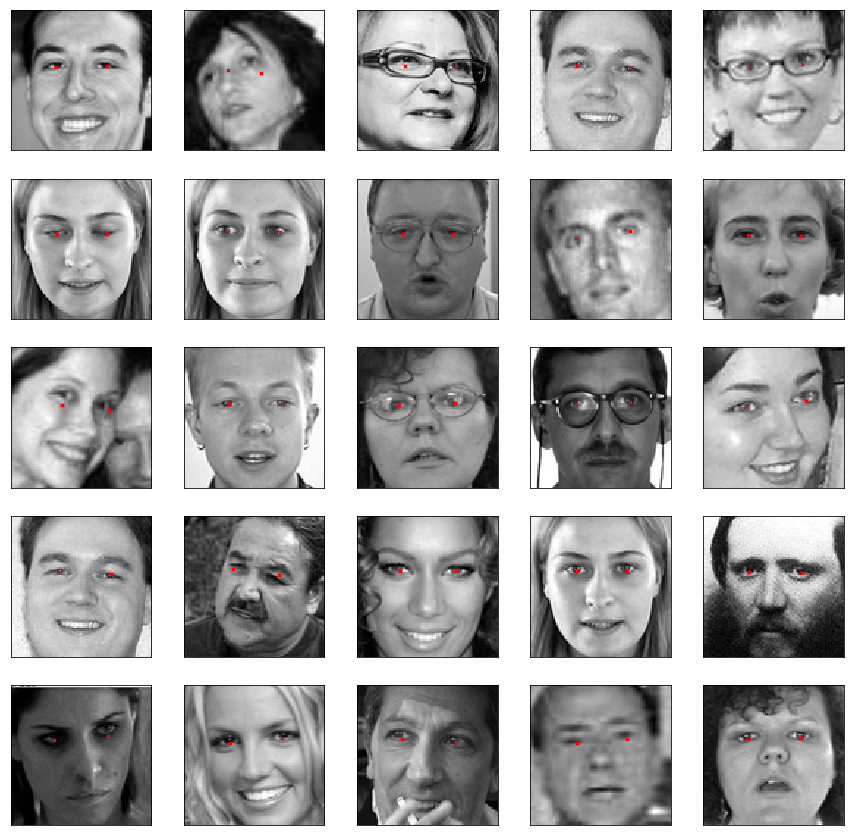

In [716]:
fig = plt.figure(figsize=(15, 15))

offset = 1200

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_images[i+offset]
    img = img.reshape(96, 96)
    y1 = predictions[i+offset]
    plt.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y1[0::2] * 48 + 48, y1[1::2] * 48 + 48, marker='x', s=10, color='red')
plt.show()

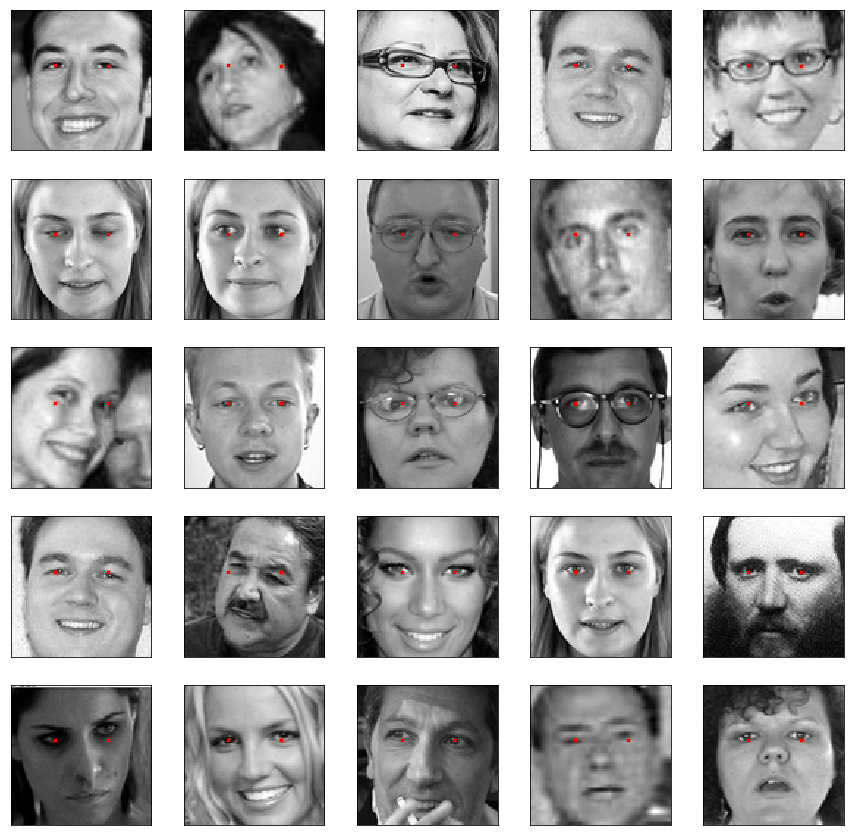

In [766]:
fig = plt.figure(figsize=(15, 15))

offset = 1200

for i in range(25):
    axis = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    img = test_images[i+offset]
    img = img.reshape(96, 96)
    y1 = predictions[i+offset]
    plt.imshow(img, cmap='gray')
    # Actual labels
    axis.scatter(y1[0::2] * 48 + 48, y1[1::2] * 48 + 48, marker='x', s=10, color='red')
plt.show()

In [748]:
train_labels.shape

(4923, 4)

In [749]:
y_train.shape

(1498, 30)

In [758]:
for j in range(0, num_labels, 2):
    print(j)

0
2
